# 利用NeuralCF进行电影推荐

数据集为MovieLens 100K，包括用户、电影和用户对电影的评分，根据已有数据，为用户推荐**还未观看过的电影**

PIPELINE：
- 通过用户-电影评分数据训练模型
- 将用户映射为低维向量表示
- 将电影映射为低维向量表示
- 计算两者的点积，获取两者的匹配程度（作为预测评分）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

## 1. 下载及导入数据

In [3]:
rawdata_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
zipped_file = keras.utils.get_file('ml-latest-small.zip', rawdata_url, cache_dir='.')


983040/978202 [==============================] - 2s 2us/step


In [23]:
keras_datasets_path = Path(zipped_file).parents[0]
movielens_dir = keras_datasets_path / 'ml-latest-small'

In [52]:
if not movielens_dir.exists():
    with ZipFile(zipped_file, 'r') as zip_file:
        print('开始文件解压...')
        zip_file.extractall(path=keras_datasets_path)
        print('解压完成！')
ratings_file = movielens_dir / 'ratings.csv'

开始文件解压...
解压完成！


In [53]:
df = pd.read_csv(ratings_file)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## 2. 数据预处理

In [61]:
user_ids = df['userId'].unique().tolist()
user2encoded_user = {x: i for i, x in enumerate(user_ids)}
encoded_user2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df['movieId'].unique().tolist()
movie2encoded_movie = {x: i for i, x in enumerate(movie_ids)}
encoded_movie2movie = {i: x for i, x in enumerate(movie_ids)}

In [71]:
df['user'] = df['userId'].map(user2encoded_user)
df['movie'] = df['movieId'].map(movie2encoded_movie)

num_users = len(user_ids)
num_movies = len(movie_ids)
df['rating'] = df['rating'].values.astype(np.float32)
min_rating = df['rating'].min()
max_rating = df['rating'].max()

print('用户总数：{}\n电影总数：{}\n最低评分：{}\n最高评分：{}'.format(
    num_users, num_movies, min_rating, max_rating))

用户总数：610
电影总数：9724
最低评分：0.5
最高评分：5.0


## 3. 数据分割

构造训练集和验证集

In [76]:
# 整体采样，就执行了shuffle的作用
df = df.sample(frac=1)

In [81]:
x = df[['user', 'movie']].values
# 将评分归一化
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_nums = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = x[:train_nums], x[train_nums:], y[:train_nums], y[train_nums:]

## 4. 构造模型及模型训练

将数据映射到低维空间，设置低维空间维数为40，用户和电影都被映射到该空间。

In [97]:
embedding_size = 40

# 注：keras.models.Model和keras.Model是同一个东西
class CF_NeuralNet(keras.models.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = keras.layers.Embedding(
            num_users, embedding_size, embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = keras.layers.Embedding(num_users, 1)
        self.movie_embedding = keras.layers.Embedding(
            num_movies, embedding_size, embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = keras.layers.Embedding(num_movies, 1)
    
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        # 将用户向量最后两个纬度和电影向量的前两个纬度做点积
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

In [98]:
model = CF_NeuralNet(num_users, num_movies, embedding_size)
model.compile(loss='binary_crossentropy', optimizer='adam', me)

In [99]:
history = model.fit(x_train, y_train, batch_size=64, 
                    epochs=10, verbose=1, use_multiprocessing=True,
                   validation_data=(x_val, y_val))

Epoch 1/10
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6361 - val_loss: 0.6194
Epoch 2/10
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6126 - val_loss: 0.6141
Epoch 3/10
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6069 - val_loss: 0.6119
Epoch 4/10
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6051 - val_loss: 0.6090
Epoch 5/10
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6041 - val_loss: 0.6095
Epoch 6/10
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6031 - val_loss: 0.6079
Epoch 7/10
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6023 - val_loss: 0.6080
Epoch 8/10
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6013 - val_loss: 0.6071
Epoch 9/10
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6006 - val_loss: 0.6073
Epoch 10/10
1418/1418 [==============================] - 8s 5ms/step - loss: 0.600

## 5. 绘制训练途中的损失图

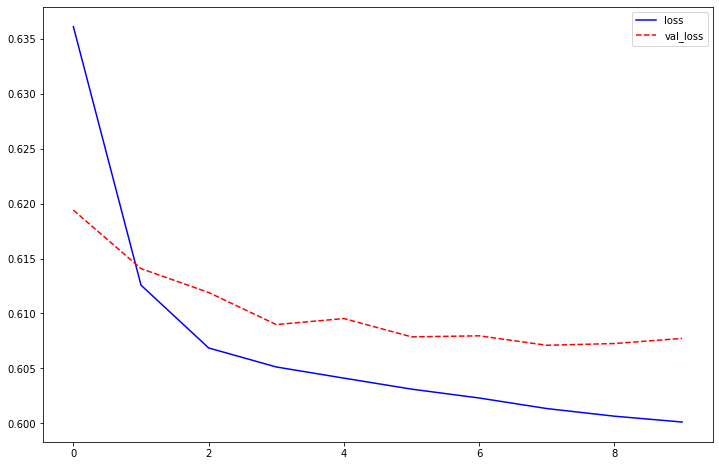

In [102]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], '-b', label='loss')
plt.plot(history.history['val_loss'], '--r', label='val_loss')
plt.legend(loc='best')

## 6. topk推荐

从没看过的电影中推荐中预测评价最高的10个

In [111]:
movie_df = pd.read_csv(movielens_dir / 'movies.csv')
user_id = df['userId'].sample(1).iloc[0]

In [138]:
movies_watched_by_user = df[df['userId'] == user_id]
movies_not_watched = movie_df[~movie_df['movieId'].isin(movies_watched_by_user['movieId'].values)]['movieId']
movies_not_watched = list(set(movies_not_watched) & (set(movie2encoded_movie.keys())))
movies_not_watched = [[movie2encoded_movie.get(x)] for x in movies_not_watched]
encoded_user = user2encoded_user.get(user_id)
user_movie_matrix = np.hstack(([[encoded_user]] * len(movies_not_watched), movies_not_watched))

In [141]:
ratings = model.predict(user_movie_matrix).flatten()

In [148]:
print('看过的电影数量：{}\n没看过的电影数量：{}'.format(num_movies-len(movies_not_watched), len(movies_not_watched)))

看过的电影数量：181
没看过的电影数量：9543


In [153]:
top_ratings_indice = ratings.argsort()[-10:][::-1]
recommend_movies_ids = [encoded_movie2movie.get(movies_not_watched[x][0]) for x in top_ratings_indice]

In [154]:
print('推荐的10部电影id为：', recommend_movies_ids)

推荐的10部电影id为： [318, 1276, 2019, 1213, 2959, 1221, 1204, 1089, 48516, 750]


In [190]:
recommend_movies = movie_df[movie_df['movieId'].isin(recommend_movies_ids)]
print('目标用户：', user_id)
print('===='*10)
num_top_rated = min(len(movies_watched_by_user), 5)
top5_rated_movies = (movies_watched_by_user.sort_values(by='rating', ascending=False).head(num_top_rated)['movieId'].values)
top5_rated_movies_df = movie_df[movie_df['movieId'].isin(top5_rated_movies)]
print('该用户评分最高的5部电影（片名；类型）：')
print('----'*10)
for row in top5_rated_movies_df.itertuples():
    print(row.title, ';', row.genres)
print('----'*10)
print('给该用户推荐的10部电影（片名；类型）：')
print('----'*10)
for row in recommend_movies.itertuples():
    print(row.title, ';', row.genres)

目标用户： 479
该用户评分最高的5部电影（片名；类型）：
----------------------------------------
Blues Brothers, The (1980) ; Action|Comedy|Musical
Groundhog Day (1993) ; Comedy|Fantasy|Romance
Mrs. Miniver (1942) ; Drama|War
Moulin Rouge (2001) ; Drama|Musical|Romance
Monsters, Inc. (2001) ; Adventure|Animation|Children|Comedy|Fantasy
----------------------------------------
给该用户推荐的10部电影（片名；类型）：
----------------------------------------
Shawshank Redemption, The (1994) ; Crime|Drama
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) ; Comedy|War
Reservoir Dogs (1992) ; Crime|Mystery|Thriller
Lawrence of Arabia (1962) ; Adventure|Drama|War
Goodfellas (1990) ; Crime|Drama
Godfather: Part II, The (1974) ; Crime|Drama
Cool Hand Luke (1967) ; Drama
Seven Samurai (Shichinin no samurai) (1954) ; Action|Adventure|Drama
Fight Club (1999) ; Action|Crime|Drama|Thriller
Departed, The (2006) ; Crime|Drama|Thriller


In [201]:
def recommend_to_user(user_id, show_top5_rated=True):
    if user_id > 610 or user_id < 1:
        print('不存在该用户，请输入介于1-610的用户id！')
        return
    movies_watched_by_user = df[df['userId'] == user_id]
    movies_not_watched = movie_df[~movie_df['movieId'].isin(movies_watched_by_user['movieId'].values)]['movieId']
    movies_not_watched = list(set(movies_not_watched) & (set(movie2encoded_movie.keys())))
    movies_not_watched = [[movie2encoded_movie.get(x)] for x in movies_not_watched]
    encoded_user = user2encoded_user.get(user_id)
    user_movie_matrix = np.hstack(([[encoded_user]] * len(movies_not_watched), movies_not_watched))
    ratings = model.predict(user_movie_matrix).flatten()
    top_ratings_indice = ratings.argsort()[-10:][::-1]
    recommend_movies_ids = [encoded_movie2movie.get(movies_not_watched[x][0]) for x in top_ratings_indice]
    recommend_movies = movie_df[movie_df['movieId'].isin(recommend_movies_ids)]
    print('目标用户：', user_id)
    print('===='*10)
    if show_top5_rated:
        num_top_rated = min(len(movies_watched_by_user), 5)
        top5_rated_movies = (movies_watched_by_user.sort_values(by='rating', ascending=False).head(num_top_rated)['movieId'].values)
        top5_rated_movies_df = movie_df[movie_df['movieId'].isin(top5_rated_movies)]
        print('该用户评分最高的5部电影（片名；类型）：')
        print('----'*10)
        for row in top5_rated_movies_df.itertuples():
            print(row.title, ';', row.genres)
        print('----'*10)
    print('给该用户推荐的10部电影（片名；类型）：')
    print('----'*10)
    for row in recommend_movies.itertuples():
        print(row.title, ';', row.genres)

In [203]:
recommend_to_user(1, show_top5_rated=False)

目标用户： 1
给该用户推荐的10部电影（片名；类型）：
----------------------------------------
Shawshank Redemption, The (1994) ; Crime|Drama
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) ; Comedy|War
Godfather, The (1972) ; Crime|Drama
One Flew Over the Cuckoo's Nest (1975) ; Drama
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) ; Action|Adventure|Western
12 Angry Men (1957) ; Drama
Lawrence of Arabia (1962) ; Adventure|Drama|War
Godfather: Part II, The (1974) ; Crime|Drama
Boot, Das (Boat, The) (1981) ; Action|Drama|War
Doctor Zhivago (1965) ; Drama|Romance|War


In [204]:
recommend_to_user(1)

目标用户： 1
该用户评分最高的5部电影（片名；类型）：
----------------------------------------
Black Cauldron, The (1985) ; Adventure|Animation|Children|Fantasy
Charlotte's Web (1973) ; Animation|Children
South Park: Bigger, Longer and Uncut (1999) ; Animation|Comedy|Musical
Thunderball (1965) ; Action|Adventure|Thriller
Blazing Saddles (1974) ; Comedy|Western
----------------------------------------
给该用户推荐的10部电影（片名；类型）：
----------------------------------------
Shawshank Redemption, The (1994) ; Crime|Drama
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) ; Comedy|War
Godfather, The (1972) ; Crime|Drama
One Flew Over the Cuckoo's Nest (1975) ; Drama
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) ; Action|Adventure|Western
12 Angry Men (1957) ; Drama
Lawrence of Arabia (1962) ; Adventure|Drama|War
Godfather: Part II, The (1974) ; Crime|Drama
Boot, Das (Boat, The) (1981) ; Action|Drama|War
Doctor Zhivago (1965) ; Drama|Romance|War
